In [34]:
import os
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.svm import SVC

from scipy.signal import savgol_filter, detrend

## 파일 불러오기 및 병합

In [2]:
# =========================
# 0. 설정
# =========================
voc_paths = {
    "voc2": "/home/gracejang42/CP/final_data/voc2/long_df.csv",
    "voc3": "/home/gracejang42/CP/final_data/voc3/long_df.csv",
    "voc4": "/home/gracejang42/CP/final_data/voc4/long_df.csv",
    "voc5": "/home/gracejang42/CP/final_data/voc5/long_df.csv",
    "voc7": "/home/gracejang42/CP/final_data/voc7/long_df.csv",
    "voc8": "/home/gracejang42/CP/final_data/voc8/long_df.csv",
    "voc9": "/home/gracejang42/CP/final_data/voc9/long_df.csv",
    "voc10": "/home/gracejang42/CP/final_data/voc10/long_df.csv",
}

## 데이터 전처리

In [3]:
BASELINE_END = 50      # baseline 구간: time_index < 50
RESP_START   = 50      # VOC 주입 이후 시작 지점
RESP_END     = 199     # 분석에 쓸 마지막 time_index

# Savitzky-Golay 파라미터
SG_WINDOW = 21   # 반드시 홀수
SG_POLY   = 3

In [14]:
# =========================
# 1. VOC CSV 로드 + 병합
# =========================
dfs = []

for name, path in voc_paths.items():
    print(f"📂 Loading: {name} → {path}")
    df = pd.read_csv(path)

    required_cols = {"sample_id", "time_index", "sensor", "intensity"}
    assert required_cols.issubset(df.columns), f"{name} 컬럼 구조 오류!"

    df["sample_id"] = df["sample_id"].astype(int)
    df["time_index"] = df["time_index"].astype(int)

    df["dataset"] = name          # 'voc1' ~ 'voc10'
    df["label_name"] = name       # 나중에 라벨로 사용
    df["sample_key"] = name + "_" + df["sample_id"].astype(str)  # 예: voc3_5

    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print("\n🔍 merged long df shape:", df_all.shape)
df_all

📂 Loading: voc2 → /home/gracejang42/CP/final_data/voc2/long_df.csv
📂 Loading: voc3 → /home/gracejang42/CP/final_data/voc3/long_df.csv
📂 Loading: voc4 → /home/gracejang42/CP/final_data/voc4/long_df.csv
📂 Loading: voc5 → /home/gracejang42/CP/final_data/voc5/long_df.csv
📂 Loading: voc7 → /home/gracejang42/CP/final_data/voc7/long_df.csv
📂 Loading: voc8 → /home/gracejang42/CP/final_data/voc8/long_df.csv
📂 Loading: voc9 → /home/gracejang42/CP/final_data/voc9/long_df.csv
📂 Loading: voc10 → /home/gracejang42/CP/final_data/voc10/long_df.csv

🔍 merged long df shape: (576000, 7)


,sample_id,time_index,sensor,intensity,dataset,label_name,sample_key
0,1,0,pos1_Sensor2,542.419136,voc2,voc2,voc2_1
1,1,0,pos1_Sensor1,163.974254,voc2,voc2,voc2_1
2,1,0,pos1_Sensor11,823.123927,voc2,voc2,voc2_1
3,1,0,pos1_Sensor12,615.730435,voc2,voc2,voc2_1
4,1,0,pos2_Sensor4,472.492491,voc2,voc2,voc2_1
...,...,...,...,...,...,...,...
575995,10,199,pos8_Sensor34,151.336330,voc10,voc10,voc10_10
575996,10,199,pos9_Sensor30,270.724714,voc10,voc10,voc10_10
575997,10,199,pos9_Sensor29,567.987076,voc10,voc10,voc10_10
575998,10,199,pos9_Sensor31,1014.048324,voc10,voc10,voc10_10


In [18]:
# =========================
# 2. Baseline Correction: (I - I0) / I0
# =========================
def apply_baseline_norm(df, baseline_end=BASELINE_END):
    df = df.copy()
    df["norm_intensity"] = np.nan

    for (sample_key, sensor), g in df.groupby(["sample_key", "sensor"]):
        g = g.sort_values("time_index")
        idx = g.index

        baseline_region = g[g["time_index"] < baseline_end]
        if len(baseline_region) == 0:
            continue

        I0 = baseline_region["intensity"].mean()
        if I0 == 0 or np.isnan(I0):
            continue

        df.loc[idx, "norm_intensity"] = (g["intensity"].values - I0) / I0

    return df

print("\n⚙ Baseline normalization ((I-I0)/I0) 적용 중...")
df_all = apply_baseline_norm(df_all)
print("norm_intensity NaN 비율:", df_all["norm_intensity"].isna().mean())


⚙ Baseline normalization ((I-I0)/I0) 적용 중...
norm_intensity NaN 비율: 0.0


In [19]:
# =========================
# 3. Noise Filtering: Savitzky-Golay smoothing
# =========================
def apply_savgol(df, col_in="norm_intensity", col_out="sg_intensity",
                 window=SG_WINDOW, poly=SG_POLY):
    df = df.copy()
    df[col_out] = np.nan

    for (sample_key, sensor), g in df.groupby(["sample_key", "sensor"]):
        g = g.sort_values("time_index")
        idx = g.index
        y = g[col_in].values

        if np.all(np.isnan(y)):
            continue

        # NaN 처리: 일단 간단히 NaN → 0 (필요시 더 고급 방식으로 바꿀 수 있음)
        y = np.nan_to_num(y, nan=0.0)

        # window length 조정
        win = min(window, len(y))
        if win < 3:
            df.loc[idx, col_out] = y
            continue
        if win % 2 == 0:
            win -= 1
        if win < 3:
            win = 3

        y_sg = savgol_filter(y, window_length=win, polyorder=poly, mode="interp")
        df.loc[idx, col_out] = y_sg

    return df

In [20]:
from scipy.signal import savgol_filter

print("\n⚙ Savitzky-Golay smoothing 적용 중...")
df_all = apply_savgol(df_all, col_in="norm_intensity", col_out="sg_intensity")
print("sg_intensity NaN 비율:", df_all["sg_intensity"].isna().mean())


⚙ Savitzky-Golay smoothing 적용 중...
sg_intensity NaN 비율: 0.0


In [21]:
# =========================
# 4. Drift Removal: linear detrend (센서별 시간 추세 제거)
# =========================
def apply_drift_removal(df, col_in="sg_intensity", col_out="detrended_intensity"):
    df = df.copy()
    df[col_out] = np.nan

    for (sample_key, sensor), g in df.groupby(["sample_key", "sensor"]):
        g = g.sort_values("time_index")
        idx = g.index
        y = g[col_in].values

        if np.all(np.isnan(y)):
            continue

        y = np.nan_to_num(y, nan=0.0)

        # scipy.signal.detrend 로 linear trend 제거
        y_detrend = detrend(y, type="linear")
        df.loc[idx, col_out] = y_detrend

    return df

print("\n⚙ Drift removal (linear detrend) 적용 중...")
df_all = apply_drift_removal(df_all, col_in="sg_intensity", col_out="detrended_intensity")
print("detrended_intensity NaN 비율:", df_all["detrended_intensity"].isna().mean())


⚙ Drift removal (linear detrend) 적용 중...
detrended_intensity NaN 비율: 0.0


In [27]:
# =========================
# 5. Segment Selection + Feature Extraction
#    - 분석 구간: RESP_START ~ RESP_END
#    - Feature:
#        * AUC (합)
#        * max_response
#        * time_to_peak (index 차이)
#        * max_slope (1차 차분 최대값)
#        * steady_state (마지막 20포인트 평균)
# =========================

feature_rows = []

for (sample_key, sensor), g in df_all.groupby(["sample_key", "sensor"]):
    g = g.sort_values("time_index")

    # 분석 구간 선택
    mask = (g["time_index"] >= RESP_START) & (g["time_index"] <= RESP_END)
    seg = g[mask]

    if len(seg) < 5:
        continue

    t = seg["time_index"].values.astype(float)
    y = seg["detrended_intensity"].values.astype(float)
    y = np.nan_to_num(y, nan=0.0)

    # --- Feature 1: AUC (여기서는 Δt=1 가정 → 단순 합) ---
    auc = np.trapz(y, t)  # integral approximation

    # --- Feature 2: max_response ---
    max_resp = np.max(y)

    # --- Feature 3: time_to_peak (최대값까지의 시간 차) ---
    peak_idx = np.argmax(y)
    time_to_peak = t[peak_idx] - t[0]

    # --- Feature 4: max_slope (1차 차분 최대값) ---
    dy = np.diff(y)
    if len(dy) > 0:
        max_slope = np.max(dy)
    else:
        max_slope = 0.0

    # --- Feature 5: steady_state (마지막 20포인트 평균, 부족하면 전체 평균) ---
    if len(y) >= 20:
        steady_state = np.mean(y[80:100])
    else:
        steady_state = np.mean(y)

    dataset = g["dataset"].iloc[0]
    label_name = g["label_name"].iloc[0]

    feature_rows.append({
        "sample_key": sample_key,
        "dataset": dataset,
        "label_name": label_name,
        "sensor": sensor,
        "AUC": auc,
        "max_response": max_resp,
        "time_to_peak": time_to_peak,
        "max_slope": max_slope,
        "steady_state": steady_state,
    })

feat_long = pd.DataFrame(feature_rows)
print("\n✅ Feature long-format shape:", feat_long.shape)
print(feat_long.head())

/tmp/ipykernel_2119527/1204660241.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, t)  # integral approximation



✅ Feature long-format shape: (2880, 9)
  sample_key dataset label_name         sensor       AUC  max_response  \
0    voc10_1   voc10      voc10   pos1_Sensor1 -0.432688      0.061449   
1    voc10_1   voc10      voc10  pos1_Sensor11 -0.070821      0.017509   
2    voc10_1   voc10      voc10  pos1_Sensor12 -0.065212      0.022114   
3    voc10_1   voc10      voc10   pos1_Sensor2 -0.066881      0.021083   
4    voc10_1   voc10      voc10  pos2_Sensor10 -0.102199      0.027677   

   time_to_peak  max_slope  steady_state  
0         149.0   0.016574     -0.009402  
1         149.0   0.004472     -0.004924  
2         149.0   0.006270     -0.005016  
3         149.0   0.005995     -0.007430  
4         149.0   0.010550      0.001780  


In [28]:
# =========================
# 6. ML용 wide feature matrix로 변환
#    → row = sample_key
#    → col = sensor_feature (예: Sensor1_AUC)
# =========================

# 센서+특징을 컬럼으로 pivot
feat_wide = feat_long.pivot_table(
    index="sample_key",
    columns="sensor",
    values=["AUC", "max_response", "time_to_peak", "max_slope", "steady_state"]
)

# MultiIndex 컬럼을 "sensor_feature" 형태로 평탄화
feat_wide.columns = [f"{sensor}_{feat}"
                     for feat, sensor in feat_wide.columns]

# 라벨 정보 붙이기
labels = feat_long.groupby("sample_key")["label_name"].first()
datasets = feat_long.groupby("sample_key")["dataset"].first()

feat_wide = feat_wide.loc[labels.index]  # 정렬 맞추기
feat_wide["label_name"] = labels
feat_wide["dataset"] = datasets

print("\n🎯 최종 ML Feature Matrix shape:", feat_wide.shape)
print(feat_wide.head())

# 원하면 CSV로 저장
out_path = "/home/gracejang42/CP/final_data/processed_features_AUC_slope_peak.csv"
feat_wide.to_csv(out_path)
print(f"\n💾 Saved feature matrix to: {out_path}")


🎯 최종 ML Feature Matrix shape: (80, 182)
            pos1_Sensor1_AUC  pos1_Sensor11_AUC  pos1_Sensor12_AUC  \
sample_key                                                           
voc10_1            -0.432688          -0.070821          -0.065212   
voc10_10           -0.188367          -0.031374          -0.072429   
voc10_2             0.197015           0.104744           0.055276   
voc10_3            -0.101126           0.013053          -0.019408   
voc10_4            -0.142645          -0.053090           0.009737   

            pos1_Sensor2_AUC  pos2_Sensor10_AUC  pos2_Sensor3_AUC  \
sample_key                                                          
voc10_1            -0.066881          -0.102199          0.018538   
voc10_10            0.004570          -0.047839         -0.064675   
voc10_2             0.080302           0.078206          0.050437   
voc10_3             0.008832          -0.001402         -0.018233   
voc10_4             0.004638           0.001300       

## RF

In [31]:
feat_filtered = feat_wide

feature_cols = [c for c in feat_filtered.columns if c not in ["label_name", "dataset"]]

X = feat_filtered[feature_cols].values.astype(float)
labels = feat_filtered["label_name"].values

le = LabelEncoder()
y = le.fit_transform(labels)
class_names = list(le.classes_)

print("\n🔹 Processed feature shape:", X.shape)
print("🔹 Class count:", dict(zip(*np.unique(labels, return_counts=True))))
print("Class mapping:", {i: c for i, c in enumerate(class_names)})


🔹 Processed feature shape: (80, 180)
🔹 Class count: {'voc10': np.int64(10), 'voc2': np.int64(10), 'voc3': np.int64(10), 'voc4': np.int64(10), 'voc5': np.int64(10), 'voc7': np.int64(10), 'voc8': np.int64(10), 'voc9': np.int64(10)}
Class mapping: {0: 'voc10', 1: 'voc2', 2: 'voc3', 3: 'voc4', 4: 'voc5', 5: 'voc7', 6: 'voc8', 7: 'voc9'}


In [32]:
# -------------------------------------------------
# 3) Random Forest 모델
# -------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# CV performance
rf_scores = cross_val_score(rf, X, y, cv=skf)

print(f"\n🌲 RF Accuracy (Processed features / VOC1 removed) = {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print("Fold scores:", rf_scores)



🌲 RF Accuracy (Processed features / VOC1 removed) = 0.2875 ± 0.1375
Fold scores: [0.25  0.375 0.375 0.25  0.25  0.125 0.    0.5   0.375 0.375]



===== Random Forest Classification Report (VOC1 Removed) =====
              precision    recall  f1-score   support

       voc10       0.23      0.30      0.26        10
        voc2       0.33      0.50      0.40        10
        voc3       0.17      0.10      0.12        10
        voc4       0.57      0.40      0.47        10
        voc5       0.30      0.30      0.30        10
        voc7       0.36      0.40      0.38        10
        voc8       0.25      0.30      0.27        10
        voc9       0.00      0.00      0.00        10

    accuracy                           0.29        80
   macro avg       0.28      0.29      0.28        80
weighted avg       0.28      0.29      0.28        80



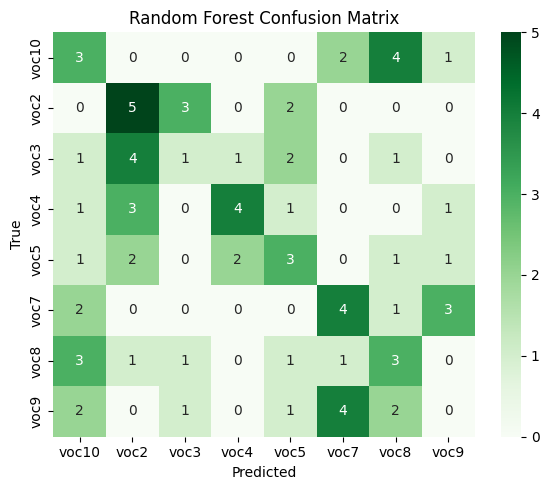

In [33]:
# -------------------------------------------------
# 4) Classification Report & Confusion Matrix
# -------------------------------------------------
y_pred_rf = cross_val_predict(rf, X, y, cv=skf)

print("\n===== Random Forest Classification Report (VOC1 Removed) =====")
print(classification_report(y, y_pred_rf, target_names=class_names))

cm_rf = confusion_matrix(y, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## SVM

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
# ====================================
# 5) SVM 모델
# ====================================
svm_model = SVC(kernel="rbf", C=10, gamma="scale", random_state=42)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_scaled, y, cv=skf)

print(f"\n🎯 SVM Accuracy (VOC1 removed) = {scores.mean():.4f} ± {scores.std():.4f}")
print("Fold scores:", scores)

# ====================================
# 6) Confusion Matrix & Report
# ====================================
y_pred = cross_val_predict(svm_model, X_scaled, y, cv=skf)

print("\n===== Classification Report (VOC1 removed) =====")
print(classification_report(y, y_pred, target_names=class_names))


🎯 SVM Accuracy (VOC1 removed) = 0.2000 ± 0.1146
Fold scores: [0.25  0.125 0.375 0.125 0.125 0.125 0.    0.375 0.25  0.25 ]

===== Classification Report (VOC1 removed) =====
              precision    recall  f1-score   support

       voc10       0.11      0.10      0.11        10
        voc2       0.40      0.40      0.40        10
        voc3       0.18      0.20      0.19        10
        voc4       0.43      0.30      0.35        10
        voc5       0.17      0.20      0.18        10
        voc7       0.20      0.20      0.20        10
        voc8       0.08      0.10      0.09        10
        voc9       0.12      0.10      0.11        10

    accuracy                           0.20        80
   macro avg       0.21      0.20      0.20        80
weighted avg       0.21      0.20      0.20        80



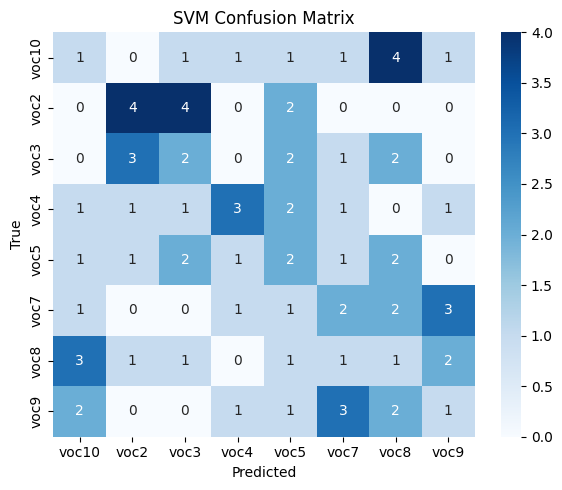

In [37]:
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()